<a href="https://colab.research.google.com/github/Samira-Alipour/SocialMediaApp/blob/main/Banking_Analytics_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df1 is the dataframe for bonds and df1 is the dataframe for teh rates

import pandas as pd
import numpy as np
import os


filename = '/content/drive/MyDrive/DataClean2021_update_data.xlsx'
filename1 = '/content/drive/MyDrive/DataClean2021.xlsx'


df = pd.read_excel(filename, 0)
df1 = pd.read_excel(filename1, 1)



In [ ]:
!pip install numpy_financial
import numpy_financial as npf
import datetime

This is a function to return bond parameters, if index==1 it will also return the calculated maturity.


In [ ]:
def return_bond_param(bond_info, index = 0):

    if bond_info['PaymentPeriod'] not in ['Annually','SemiAnnually', 'Quarterly']:
        print("The freq of the bond is unknown")
  
    if bond_info['PaymentPeriod'] == 'Annually':
        freq = 1
    elif bond_info['PaymentPeriod'] == 'SemiAnnually':
        freq = 2
    elif bond_info['PaymentPeriod'] == 'Quarterly':
        freq = 4
    else:
        freq = None
        print("freq is None")

    Spread = bond_info['Spread']
    FaceValue = bond_info['FaceValue']
    YearlyRate = bond_info['YearlyRate']
    Price0 = bond_info['PriceAtCoupon0(%)'] / 100
    PurchaseDate0 = bond_info['PurchaseDate']
    PurchaseDate = datetime.date(PurchaseDate0.year, PurchaseDate0.month, PurchaseDate0.day)
    Corporate = bond_info['Corporate']
    CurrentCouponNumbers = bond_info['CurrentCouponNumbers']
    if index == 1:
      maturity_calculated = bond_info['maturity_calculated']
    else:
      maturity_calculated = None

    return FaceValue, YearlyRate, Spread, Price0, freq, PurchaseDate, Corporate, CurrentCouponNumbers, maturity_calculated


This is the function to retrive the correponding rates for an specific bond. The output will only have curve points that are needed for pricing the specific bond, depending on the maturity and frequency of coupon payments.

In [ ]:

def get_spot_rate(curve, freq, maturity, curve_freq = 4, max_maturity = 30):
    if len(curve) != curve_freq * max_maturity:
        print('The length of the curve is not correct')
    else:
        spot_rate = curve[int(curve_freq/freq-1):int(maturity*curve_freq):int(curve_freq/freq)]

    return spot_rate


Main bond pricing function

In [ ]:
def BondPrice(spot_rate, Maturity, rate, spread, FV, freq=1, CurrentCouponNumbers=0):
    Number_of_coupons = int(Maturity * freq) 
    if Number_of_coupons>0:
        rate = rate / freq

        y = np.zeros(Number_of_coupons + 1)

        y[1:] = spot_rate / freq  + spread  
        payment_series = np.repeat(rate, Number_of_coupons+1)
        payment_series[0] -= rate 
        payment_series[Number_of_coupons]  += 1 


        if CurrentCouponNumbers>0:
            payment_series = payment_series[CurrentCouponNumbers:]
            payment_series[0] = 0
            y = y[:-CurrentCouponNumbers]


        price = npf.npv(y, payment_series)
    else:
        price = 9999
    return price


Function to return the time between the last copoun date and Todays Date; in this case 25 August 2021


In [ ]:
def return_time_from_last_coupon(TodayDate, PurchaseDate, freq, CurrentCouponNumbers):

    freq_days = 365 / freq
    
    date_difference = TodayDate - PurchaseDate

    time_from_last_coupon = (date_difference.days - CurrentCouponNumbers * freq_days) % freq_days

    return time_from_last_coupon


A function to return the discount factor to account for the time between the last copoun payment and Todays date; In this case 25 August 2021

In [ ]:
def return_discount_factor(spot_rates, time_from_last_coupon, Spread, freq):

    K = time_from_last_coupon/(365/freq)

    discount_facror = (1 + Spread + spot_rates[1])**K
    return discount_facror


# Part (a) of the assignment; Using grid search method to find the maturity of the bond and output it to 'Output_Calculated_Maturities.xlsx' file


In [ ]:

grid_search_freq = 4
Max_maturity = 30
grid_search = np.arange(1, grid_search_freq * Max_maturity + 1)/grid_search_freq

derived_maturity = np.zeros(len(df['PurchaseDate']))
grid_search_error = np.zeros(len(df['PurchaseDate']))
Total_Coupon_Number = np.zeros(len(df['PurchaseDate']))


for kk, bond in df.iterrows():
  FaceValue, YearlyRate, Spread, Price0, freq, PurchaseDate, Corporate, CurrentCouponNumbers, maturity_calculated = return_bond_param(bond)

  for ii, i in enumerate(df1['Date']):
    if i == PurchaseDate:
      curve = df1.loc[ii][2:].values.astype('float64')

  price_search = [BondPrice(get_spot_rate(curve,freq,d), d, YearlyRate, Spread, FaceValue, freq, 0) for dd, d in enumerate(grid_search)]
  price_search = np.array(price_search).astype('float64')
  delta = np.abs(price_search - Price0)

  maturity_result = np.min(grid_search[np.where(delta == np.min(delta))])
  P = BondPrice(get_spot_rate(curve,freq,maturity_result), maturity_result, YearlyRate, Spread, FaceValue, freq)
  derived_maturity[kk] = maturity_result
  grid_search_error[kk] = P - Price0
  Total_Coupon_Number[kk] = maturity_result * freq
    

df['maturity_calculated'] = derived_maturity
df['grid_search_error'] = grid_search_error
df['Total_Coupon_Number'] = Total_Coupon_Number
df.to_excel(r'/content/drive/MyDrive/Output_Calculated_Maturities.xlsx', index = False)

df2 is the output from part (a) of the assignment. the two columns "**maturity_calculated**" refers to the maturities and "**grid_search_error**" refers to the error from grid search method.

In [ ]:
filename2 = '/content/drive/MyDrive/Output_Calculated_Maturities.xlsx'

df2 = pd.read_excel(filename2, 0)
df2['maturity_calculated']

0         30
1         27
2         27
3         20
4          9
          ..
124804    22
124805    21
124806    22
124807    26
124808    22
Name: maturity_calculated, Length: 124809, dtype: int64

In [ ]:
df2.columns

Index(['Unnamed: 0', 'PurchaseDate', 'PriceAtCoupon0(%)', 'PaymentPeriod',
       'YearlyRate', 'Spread', 'CurrentCouponNumbers', 'FaceValue',
       'Corporate', 'CouponRate', 'maturity_calculated', 'grid_search_error',
       'Total_Coupon_Number'],
      dtype='object')

# Part (b) of the assignmnet is implemented to derive the present value for 25/08/2021


In [ ]:

TodaysDate = datetime.date(2021,8,25)

August_Price = np.zeros(len(df2['PurchaseDate']))

for ii, i in enumerate(df1['Date']):
    if datetime.date(i.year, i.month, i.day) == TodaysDate:
        print('i %s TodaysDate %s' %(i,TodaysDate))
        curve = df1.loc[ii][2:].values.astype('float64')

for kk, bond in df2.iterrows():
  FaceValue, YearlyRate, Spread, Price0, freq, PurchaseDate, Corporate, CurrentCouponNumbers, maturity_calculated = return_bond_param(bond, 1)

  spot_rates = get_spot_rate(curve, freq, maturity_calculated)

  time_from_last_coupon = return_time_from_last_coupon(TodaysDate, PurchaseDate, freq, CurrentCouponNumbers)

  discount_factor = return_discount_factor(spot_rates, time_from_last_coupon, Spread, freq)

  price = BondPrice(spot_rates, maturity_calculated, YearlyRate, Spread, FaceValue, freq, CurrentCouponNumbers)

  price_discounted_back = price * discount_factor

  August_Price[kk] = price_discounted_back


df2['August_Price(%)'] = August_Price
df2.to_excel(r'/content/drive/MyDrive/Output_Calculated_August_Price.xlsx', index = False)

i 2021-08-25 00:00:00 TodaysDate 2021-08-25


Here **August_Price(%)** column refers to the calculated price for 25 August 2021. 


In [ ]:
filename3 = '/content/drive/MyDrive/Output_Calculated_August_Price.xlsx'

df3 = pd.read_excel(filename3, 0)
print(df3.head)

<bound method NDFrame.head of         Unnamed: 0 PurchaseDate  ...  Total_Coupon_Number August_Price(%)
0                0   2018-12-12  ...                   30        1.356180
1                1   2018-12-12  ...                   54        0.713410
2                2   2018-12-12  ...                   54        0.978663
3                3   2018-12-12  ...                   40        0.994466
4                4   2018-12-12  ...                    9        1.209320
...            ...          ...  ...                  ...             ...
124804      124804   2005-09-07  ...                   22        1.291379
124805      124805   2005-09-07  ...                   42        1.118472
124806      124806   2005-09-07  ...                   22        1.269052
124807      124807   2005-09-07  ...                   52        1.039628
124808      124808   2005-09-07  ...                   44        1.087372

[124809 rows x 14 columns]>


The figure shows the price change of the bonds (%), compared to their purchase price. We can see that most of the bonds have increased in value, due to the low-risk free rates.  


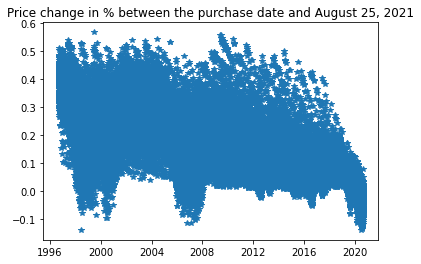

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
dp = df3['August_Price(%)'] - df3['PriceAtCoupon0(%)'].values/100  

plt.plot_date(df3['PurchaseDate'], dp ,'*')
ax.set_title('Price change in % between the purchase date and August 25, 2021')
plt.show()

# Part (c) of the assignment to calculate the capital.


This section computes the annualized spread for the bonds


In [ ]:
Anualized_Spread = np.zeros(len(df3['PurchaseDate']))

for kk, bond in df3.iterrows():
  FaceValue, YearlyRate, Spread, Price0, freq, PurchaseDate, Corporate, CurrentCouponNumbers, maturity_calculated = return_bond_param(bond, 1)

  Anualized_Spread[kk] = freq * Spread

df3['Anualized_Spread'] = Anualized_Spread


Histogram of annual spreads of bons, using to get PDs

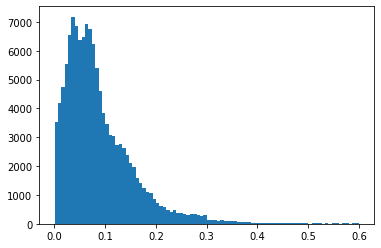

In [ ]:
plt.hist(Anualized_Spread, 90)
plt.show()

A function to compute the percentiles on annualized spreads for PD calculations


In [ ]:

percentiles = np.zeros(7)
percentiles[0] =np.percentile(Anualized_Spread, 5)
percentiles[1] =np.percentile(Anualized_Spread, 20)
percentiles[2] =np.percentile(Anualized_Spread, 40)
percentiles[3] =np.percentile(Anualized_Spread, 60)
percentiles[4] =np.percentile(Anualized_Spread, 75)
percentiles[5] =np.percentile(Anualized_Spread, 90)
percentiles[6] =np.percentile(Anualized_Spread, 100)

print(percentiles)

[0.01120205 0.03379628 0.05847847 0.08435983 0.11750605 0.17286559
 0.6       ]


A function to return PD based on annualized spreads 


In [ ]:
def return_bond_PD(anualized_spread, percentiles):
  PD = 0
  if anualized_spread<=percentiles[0]:
    PD = 0.001
  elif anualized_spread<=percentiles[1] and anualized_spread>percentiles[0]:
    PD = 0.01
  elif anualized_spread<=percentiles[2] and anualized_spread>percentiles[1]:
    PD = 0.12
  elif anualized_spread<=percentiles[3] and anualized_spread>percentiles[2]:
    PD = 0.36
  elif anualized_spread<=percentiles[4] and anualized_spread>percentiles[3]:
    PD = 0.52
  elif anualized_spread<=percentiles[5] and anualized_spread>percentiles[4]:
    PD = 0.75
  elif anualized_spread>percentiles[5]:
    PD = 0.85
  if anualized_spread == percentiles[6]:
    PD = 1
  return PD

This section computes the PD, annualized spreads

> Indented block




In [ ]:
PD = np.zeros(len(df3['PurchaseDate']))
PD_floor = 0.0003
for kk, bond in df3.iterrows():
  FaceValue, YearlyRate, Spread, Price0, freq, PurchaseDate, Corporate, CurrentCouponNumbers, maturity_calculated = return_bond_param(bond, 1)

  anualized_spread = freq * Spread
  bond_PD = return_bond_PD(anualized_spread, percentiles)
  if bond_PD < PD_floor:
    bond_PD = PD_floor
  PD[kk] = bond_PD

df3['PD'] = PD


LGD = For sunordinated bonds, LGD of 75% is used

PD = PD is the greater
of the one-year PD associated with the internal borrower grade to which that exposure is
assigned, or 0.03%

https://www.osfi-bsif.gc.ca/Eng/fi-if/rg-ro/gdn-ort/gl-ld/Pages/CAR19_chpt6.aspx#ToC63Rulesforcorporate%2csovereign%2candbankexposures


Function to return capital capital_requirement

In [ ]:
from scipy.stats import norm
def capital_requirement(PD, LGD, M):
  R =  0.12 * ( (1 - np.exp(-50 * PD)) / (1 - np.exp(-50)) )
  R += 0.24 * (1 - ( (1 - np.exp(-50 * PD)) / (1 - np.exp(-50)) ) )
  K = norm.cdf(np.sqrt( (1 - R) ** (-1) ) * norm.ppf(PD) + 
               np.sqrt( R / (1 - R) ) * norm.ppf(0.999) ) - PD
  b=(0.11852 - 0.05478*np.log( PD ))**2
  Ma=(1+(M-2.5)*b)/(1-1.5*b)
  K = K * LGD *Ma
  return(K) 

In [ ]:
print(df3.head)

<bound method NDFrame.head of         Unnamed: 0 PurchaseDate  ...  Anualized_Spread    PD
0                0   2018-12-12  ...          0.048157  0.12
1                1   2018-12-12  ...          0.170899  0.75
2                2   2018-12-12  ...          0.054181  0.12
3                3   2018-12-12  ...          0.053833  0.12
4                4   2018-12-12  ...          0.034201  0.12
...            ...          ...  ...               ...   ...
124804      124804   2005-09-07  ...          0.071007  0.36
124805      124805   2005-09-07  ...          0.040119  0.12
124806      124806   2005-09-07  ...          0.014886  0.01
124807      124807   2005-09-07  ...          0.072272  0.36
124808      124808   2005-09-07  ...          0.056948  0.12

[124809 rows x 16 columns]>


Here the main calculation of **provisions** and **unexpected** loss happens

In [ ]:
Maturities = df3['maturity_calculated'].values

EAD =  df3['FaceValue'].values * df3['August_Price(%)'].values
PD = df3['PD'].values
LGD = 0.75

K = capital_requirement(PD, LGD, Maturities)
Capital_Requirements = capital_requirement(PD, LGD, Maturities) * EAD

Provisions = PD * LGD * EAD

Risk_Weighted_Assets = np.sum(Capital_Requirements) / (0.115)



Text(0.5, 1.0, 'Histogram of K')

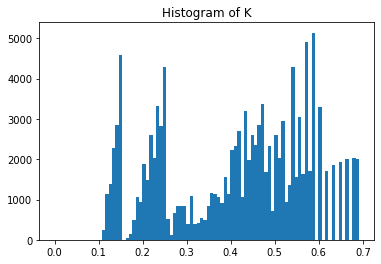

In [ ]:
fig, ax = plt.subplots()
plt.hist(K, 90)

ax.set_title('Histogram of K')

Histograms of Capital Requirement and Provisions

Text(0.5, 1.0, 'Histogram of Provisions')

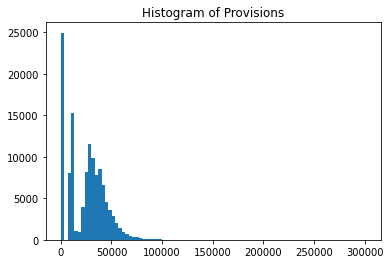

In [ ]:
fig, ax = plt.subplots()
plt.hist(Provisions, 90)

ax.set_title('Histogram of Provisions')


Text(0.5, 1.0, 'Histogram of Capital_Requirements')

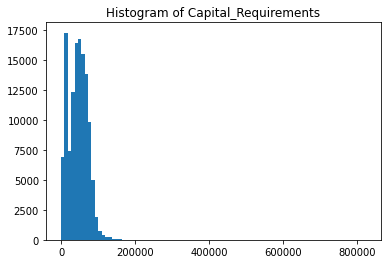

In [ ]:
fig, ax = plt.subplots()
ax.hist(Capital_Requirements, 90)

ax.set_title('Histogram of Capital_Requirements')


**Total Capital Requirement and Provisions**

In [ ]:
print('Total Provisions is: %f million dollars' %(np.sum(Provisions)/1000000))
print('Total Capital Requirements is: %f million dollars' %(np.sum(Capital_Requirements)//1000000))

Total Provisions is: 3090.176997 million dollars
Total Capital Requirements is: 5823.000000 million dollars


In [ ]:

df3['Provisions'] = Provisions
df3['Capital_Requirements'] = Capital_Requirements

df3.to_excel(r'/content/drive/MyDrive/Output_Assignment1.xlsx', index = False)